In [ ]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
len(model.vocab)

# 70. 単語ベクトルの和による特徴量

In [10]:
import numpy as np
import re
from functools import reduce
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer

In [11]:
def load_data(dir_name, file_name):
    with open(f'{dir_name}{file_name}') as f:
        X = list()
        Y = list()
        for line in f:
            line = line.strip()
            splited_line = line.split('\t')
            X.append(splited_line[0])
            Y.append(splited_line[1])
        return np.asarray(X), np.asarray(Y)

def txt2vec(x):
    vec_x_list = list()
    for text in x:
        words = word_tokenize(text)
        words_vec = [model[word] for word in words if word in model]
        if not words_vec:
            print(words)
            continue
        vec_x_list.append(sum(words_vec) / len(words_vec))
    return np.asarray(vec_x_list)

def save_file_npy(dir_name, file_name, x):
    np.save(f'{dir_name}{file_name}', x)
        
def load_file_npy(dir_name, file_name):
    return np.load(f'{dir_name}{file_name}')

def chr2num(y):
    converter = {'b':0, 't':1, 'e':2, 'm':3}
    return np.asarray([converter[article_type] for article_type in y])

In [ ]:
train_x, train_y = load_data('data/', 'train.txt')
valid_x, valid_y = load_data('data/', 'valid.txt')
test_x, test_y = load_data('data/', 'test.txt')

In [ ]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

In [ ]:
train_x = txt2vec(train_x)
valid_x = txt2vec(valid_x)
test_x = txt2vec(test_x)

In [ ]:
train_y = chr2num(train_y)
valid_y = chr2num(valid_y)
test_y = chr2num(test_y)

In [ ]:
save_file_npy('work/', 'train_x', train_x)
save_file_npy('work/', 'train_y', train_y)
save_file_npy('work/', 'valid_x', valid_x)
save_file_npy('work/', 'valid_y', valid_y)
save_file_npy('work/', 'test_x', test_x)
save_file_npy('work/', 'test_y', test_y)

# 71. 単層ニューラルネットワークによる予測

In [ ]:
train_x = load_file_npy('work/', 'train_x.npy')
train_y = load_file_npy('work/', 'train_y.npy')
valid_x = load_file_npy('work/', 'valid_x.npy')
valid_y = load_file_npy('work/', 'valid_y.npy')
test_x = load_file_npy('work/', 'test_x.npy')
test_y = load_file_npy('work/', 'test_y.npy')

In [ ]:
print(train_x.shape, train_y.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable

In [ ]:
torch.manual_seed(3)
W = torch.randn(300, 4)
print(W)

In [ ]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [ ]:
print(F.softmax(torch.matmul(train_x[:1], W), dim=1))

In [ ]:
print(F.softmax(torch.matmul(train_x[:4], W), dim=1))

# 72. 損失と勾配の計算

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

In [ ]:
criterion = nn.CrossEntropyLoss()
v_train_x = train_x[:4]
v_train_y = train_y[:4]

In [ ]:
print(v_train_x)

In [ ]:
v_train_x = torch.matmul(v_train_x, W)
loss = criterion(v_train_x, v_train_y)

In [ ]:
print(loss)

In [ ]:
loss.backward()
print(W.grad)

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

In [ ]:
out = torch.matmul(train_x[:1], W)
loss = criterion(out, train_y[:1])

In [ ]:
print(loss)

In [ ]:
loss.backward()
print(W.grad)

# 73. 確率的勾配降下法による学習

In [ ]:
import tqdm

In [ ]:
train_x = load_file_npy('work/', 'train_x.npy')
train_y = load_file_npy('work/', 'train_y.npy')
valid_x = load_file_npy('work/', 'valid_x.npy')
valid_y = load_file_npy('work/', 'valid_y.npy')
test_x = load_file_npy('work/', 'test_x.npy')
test_y = load_file_npy('work/', 'test_y.npy')

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)

In [ ]:
def train(train_x, train_y, op, criterion, W, batch_size=4, nepoch=100):
    ntrain = len(train_x)
    loss_list = list()
    for epoch in tqdm.notebook.tqdm(range(nepoch)):
        sum_loss = 0
        perm = np.random.permutation(ntrain)
        for i in range(0, ntrain, batch_size):
            batch_x = torch.from_numpy(train_x[perm[i:i + batch_size]])
            batch_y = torch.from_numpy(train_y[perm[i:i + batch_size]])
            batch_x = torch.matmul(batch_x, W)
            loss = criterion(batch_x, batch_y)
            op.zero_grad()
            loss.backward()
            op.step()
            sum_loss += loss.data.item() * len(batch_x)
        loss_list.append(sum_loss / ntrain)
    return loss_list

In [ ]:
ntrain = len(train_x)
nepoch = 100
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()
result = train(train_x, train_y, op, criterion, W, batch_size=1)

In [ ]:
print(W)

In [ ]:
print(result[::10])

# 74. 正解率の計測

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def calc_acc(data_x, data_y, W):
    with torch.no_grad():
        pred_y = torch.argmax(torch.matmul(torch.from_numpy(data_x), W), dim=1)
    return accuracy_score(data_y, pred_y)

In [ ]:
print(f'test_acc={calc_acc(test_x, test_y, W)}')

In [ ]:
print(f'train_loss={calc_acc(train_x, train_y, W)}')

# 75. 損失と正解率のプロット

https://pytorch.org/docs/stable/tensorboard.html

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import tqdm

In [ ]:
def execution(data_x, data_y, op, criterion, W, batch_size=4, is_train=True):
    ndata = len(data_x)
    perm = np.random.permutation(ndata)
    sum_loss = 0
    for i in range(0, ndata, batch_size):
        op.zero_grad()
        batch_x = torch.from_numpy(data_x[perm[i:i + batch_size]])
        batch_y = torch.from_numpy(data_y[perm[i:i + batch_size]])
        if is_train:
            out = torch.matmul(batch_x, W)
            loss = criterion(out, batch_y)
            loss.backward()
            op.step()
        else:
            with torch.no_grad():
                out = torch.matmul(batch_x, W)
                loss = criterion(out, batch_y)
        sum_loss += loss.data.item() * len(batch_x)
    return sum_loss / ndata

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)
ntrain = len(train_x)
nepoch = 100
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_writer = SummaryWriter(log_dir='./work/logs/train')
valid_writer = SummaryWriter(log_dir='./work/logs/valid')
for epoch in tqdm.notebook.tqdm(range(nepoch)):
    train_loss = execution(train_x, train_y, op, criterion, W, batch_size=1)
    train_writer.add_scalar("loss", train_loss, epoch) 
    train_writer.add_scalar("accuracy", calc_acc(train_x, train_y, W), epoch)
    
    valid_loss = execution(valid_x, valid_y, op, criterion, W, batch_size=1, is_train=False)
    valid_writer.add_scalar("loss", valid_loss, epoch)
    valid_writer.add_scalar("accuracy", calc_acc(valid_x, valid_y, W), epoch)
    
train_writer.close()
valid_writer.close()

In [ ]:
from IPython.display import SVG

In [ ]:
SVG("work/loss.svg")

In [ ]:
SVG("work/accuracy.svg")

# 76. チェックポイント

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
print(W)
ntrain = len(train_x)
nepoch = 10
op = optim.SGD([W], lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm.notebook.tqdm(range(nepoch)):
    train_loss = execution(train_x, train_y, op, criterion, W, batch_size=1)
    valid_loss = execution(valid_x, valid_y, op, criterion, W, batch_size=1, is_train=False)
    torch.save({
        'epoch': epoch,
        'W': W,
        'optimizer_state_dict': op.state_dict(),
    }, f'./work/checkpoints/checkpoint_{epoch}.pt')

In [ ]:
print(W)

In [ ]:
torch.manual_seed(0)
W = nn.Parameter(torch.randn(300, 4), requires_grad=True)
checkpoint = torch.load('./work/checkpoints/checkpoint_9.pt')
op = optim.SGD([W], lr=0.01)
W = checkpoint['W']
op.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
print(W)

# 77. ミニバッチ化

使用したライブラリ
https://github.com/primitiv/primitiv

In [7]:
%%file ./src/q77.cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <cassert>
#include <primitiv/primitiv.h>
#include <primitiv/primitiv_cuda.h>
#include <functional>
#include <time.h>

using namespace std;
using namespace primitiv;
namespace F = primitiv::functions;
namespace I = primitiv::initializers;
namespace O = primitiv::optimizers;


template<typename T>
vector<vector<T>> load_data(string path) {
    fstream ifs(path);
    stringstream ss;
    string line;
    getline(ifs, line);
    ss << line;
    int size, dim;
    ss >> size >> dim;
    vector<vector<T>> data(size, vector<T> (dim));
    for (int iter = 0; iter < size; iter++) {
        ss.clear(stringstream::goodbit);
        getline(ifs, line);
        assert(line != "");
        ss << line;
        for (int i = 0; i < dim; i++) {
            ss >> data[iter][i];
        }
    }
    return data;
}

template<typename T>
vector<T> make_batch(const vector<vector<T>> &x, const vector<unsigned> &batch_ids) {
    vector<T> data;
    for(int i = 0; i < batch_ids.size(); i++) {
        for(int j = 0; j < x[batch_ids[i]].size(); j++) {
            data.emplace_back(x[batch_ids[i]][j]);
        }
    }
    return data;
};


int main(int argc, char *argv[]) {
    vector<vector<float>> train_x = load_data<float>("./work/train_x.data");
    vector<vector<unsigned>> train_y = load_data<unsigned>("./work/train_y.data");
    vector<vector<float>> valid_x = load_data<float>("./work/valid_x.data");
    vector<vector<unsigned>> valid_y = load_data<unsigned>("./work/valid_y.data");
    vector<vector<float>> test_x = load_data<float>("./work/test_x.data");
    vector<vector<unsigned>> test_y = load_data<unsigned>("./work/test_y.data");

    devices::Naive dev;
    Device::set_default(dev);

    Graph g;
    Graph::set_default(g);

    for(int batch_size=1; batch_size <= 1024; batch_size *= 2){
        Parameter pw({4, 300}, I::XavierUniform());
        float lr = 0.01;
        O::SGD optimizer(lr);
        optimizer.add(pw);

        random_device rd;
        mt19937 rng(rd());

        const unsigned nepoch = 100;
        unsigned dim = train_x[0].size();

        function<pair<float, float>(vector<vector<float>>, vector<vector<unsigned>>, bool)> execute = \
            [&](vector<vector<float>> x, vector<vector<unsigned>> y, bool is_train) {

            vector<unsigned> data_ids(x.size());
            iota(begin(data_ids), end(data_ids), 0);
            shuffle(begin(data_ids), end(data_ids), rng);
            unsigned match = 0;
            float total_loss = 0.0;
            for (unsigned ofset = 0; ofset < x.size(); ofset += batch_size) {
                const vector<unsigned> batch_ids(
                        begin(data_ids) + ofset,
                        begin(data_ids) + min<unsigned>(ofset + batch_size, x.size())
                    );
                const auto x_batch = make_batch(x, batch_ids);
                const auto y_batch = make_batch(y, batch_ids);
                g.clear();
                const Node x = F::input<Node>(Shape({dim}, batch_ids.size()), x_batch);
                const Node w = F::parameter<Node>(pw);
                const Node res = F::matmul(w, x);
                const Node loss = F::softmax_cross_entropy(res, y_batch, 0);
                Node avg_loss = F::batch::mean(loss);
                total_loss += avg_loss.to_float() * batch_ids.size();
                optimizer.reset_gradients();
                if(is_train) {
                    loss.backward();
                    optimizer.update();
                }
                vector<float> y_val = res.to_vector();
                for (unsigned i = 0; i < batch_ids.size(); i++) {
                    float maxval = -1e10;
                    int argmax = -1;
                    for (unsigned j = 0; j < 4; j++) {
                        float v = y_val[j + i * 4];
                        if (v > maxval) maxval = v, argmax = static_cast<int>(j);
                    }
                    if (argmax == y[batch_ids[i]][0]) match++;
                }
            }
            float loss = total_loss / x.size();
            float accuracy = 100.0 * match / x.size();
            return make_pair(loss, accuracy);
        };


        clock_t train_start = clock();
        for(int epoch = 0; epoch < nepoch; epoch++) {
            clock_t start = clock();
            pair<float, float> train_res = execute(train_x, train_y, true);

            pair<float, float> valid_res = execute(valid_x, valid_y, false);
        }
        float train_time = static_cast<float> (clock() - train_start) / CLOCKS_PER_SEC;
        cout << "batch_size\t" << batch_size << "\ttrain_time\t" << train_time << " [sec]" << endl;
    }
    return 0;
}

Overwriting ./src/q77.cpp


# 78. GPU上での学習

In [ ]:
//devices::Naive dev;
//Device::set_default(dev);
        
devices::CUDA dev(0);
Device::set_default(dev);

# 79. 多層ニューラルネットワーク

In [6]:
%%file ./src/q79.cpp
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <cassert>
#include <primitiv/primitiv.h>
#include <primitiv/primitiv_cuda.h>
#include <functional>
#include <time.h>

using namespace std;
using namespace primitiv;
namespace F = primitiv::functions;
namespace I = primitiv::initializers;
namespace O = primitiv::optimizers;

namespace {

template <typename Var>
class Linear : public Model {
    Parameter pw_, pb_;
    Var w_, b_;

    public:
    Linear(unsigned in_size, unsigned out_size)
        : pw_({out_size, in_size}, I::XavierUniform())
        , pb_({out_size}, I::Constant(0)) {
            add("pw", pw_);
            add("pb", pb_);
        }

    void init() {
        w_ = F::parameter<Var>(pw_);
        b_ = F::parameter<Var>(pb_);
    }

    Var forward(const Var &x) {
        return F::matmul(w_, x) + b_;
    }
};


template <typename Var>
class MLP : public Model {
    Linear<Var> first_layer;
    vector<Linear<Var>*> hidden_layers;
    Linear<Var> last_layer;
    float dropout;
    unsigned num_hidden;

    public:
    MLP(unsigned num_hidden_, unsigned hidden_dim, float dropout_) : first_layer(300, hidden_dim), last_layer(hidden_dim, 4), dropout(dropout_), num_hidden(num_hidden_) {
        add("first_layer", first_layer);
        for(int i = 0; i < num_hidden; i++) {
            Linear<Var> *hidden_layer = new Linear<Var>(hidden_dim, hidden_dim);
            hidden_layers.emplace_back(hidden_layer);
            add("hidden_layer" + to_string(i), *hidden_layers[i]);
        }
        add("last_layer", last_layer);
    }

    ~MLP(){
        for(int i = 0; i < num_hidden; i++) {
            delete hidden_layers[i];
        }
    }

    Var forward(const Var &x, bool train) {
        first_layer.init();
        for(int i = 0; i < num_hidden; i++) {
            hidden_layers[i]->init();
        }
        last_layer.init();

        Var x1 = F::dropout(F::relu(first_layer.forward(x)), dropout, train);
        for(int i = 0; i < num_hidden; i++) {
            x1 = F::dropout(F::relu(hidden_layers[i]->forward(x1)), dropout, train);
        }
        x1 = last_layer.forward(x1);
        return x1;
    }

};
}

template<typename T>
vector<vector<T>> load_data(string path) {
    fstream ifs(path);
    stringstream ss;
    string line;
    getline(ifs, line);
    ss << line;
    int size, dim;
    ss >> size >> dim;
    vector<vector<T>> data(size, vector<T> (dim));
    for (int iter = 0; iter < size; iter++) {
        ss.clear(stringstream::goodbit);
        getline(ifs, line);
        assert(line != "");
        ss << line;
        for (int i = 0; i < dim; i++) {
            ss >> data[iter][i];
        }
    }
    return data;
}

template<typename T>
vector<T> make_batch(const vector<vector<T>> &x, const vector<unsigned> &batch_ids) {
    vector<T> data;
    for(int i = 0; i < batch_ids.size(); i++) {
        for(int j = 0; j < x[batch_ids[i]].size(); j++) {
            data.emplace_back(x[batch_ids[i]][j]);
        }
    }
    return data;
};


int main(int argc, char *argv[]) {
    vector<vector<float>> train_x = load_data<float>("./work/train_x.data");
    vector<vector<unsigned>> train_y = load_data<unsigned>("./work/train_y.data");
    vector<vector<float>> valid_x = load_data<float>("./work/valid_x.data");
    vector<vector<unsigned>> valid_y = load_data<unsigned>("./work/valid_y.data");
    vector<vector<float>> test_x = load_data<float>("./work/test_x.data");
    vector<vector<unsigned>> test_y = load_data<unsigned>("./work/test_y.data");

    devices::CUDA dev(0);
    Device::set_default(dev);

    Graph g;
    Graph::set_default(g);

    ::MLP<Node> mlp(3, 300, 0.3);

    float lr = 0.0005;
    O::Adam optimizer(lr);
    optimizer.add(mlp);

    random_device rd;
    mt19937 rng(rd());
    int batch_size = 256;

    const unsigned nepoch = 100;
    unsigned dim = train_x[0].size();

    function<pair<float, float>(vector<vector<float>>, vector<vector<unsigned>>, bool)> execute = \
      [&](vector<vector<float>> x, vector<vector<unsigned>> y, bool is_train) {

      vector<unsigned> data_ids(x.size());
      iota(begin(data_ids), end(data_ids), 0);
      shuffle(begin(data_ids), end(data_ids), rng);
      unsigned match = 0;
      float total_loss = 0.0;
      for (unsigned ofset = 0; ofset < x.size(); ofset += batch_size) {
          const vector<unsigned> batch_ids(
                  begin(data_ids) + ofset,
                  begin(data_ids) + min<unsigned>(ofset + batch_size, x.size())
          );
          const auto x_batch = make_batch(x, batch_ids);
          const auto y_batch = make_batch(y, batch_ids);
          g.clear();
          const Node x = F::input<Node>(Shape({dim}, batch_ids.size()), x_batch);
          const Node res = mlp.forward(x, is_train);
          const Node loss = F::softmax_cross_entropy(res, y_batch, 0);
          Node avg_loss = F::batch::mean(loss);
          total_loss += avg_loss.to_float() * batch_ids.size();
          optimizer.reset_gradients();
          if(is_train) {
              loss.backward();
              optimizer.update();
          }
          vector<float> y_val = res.to_vector();
          for (unsigned i = 0; i < batch_ids.size(); i++) {
              float maxval = -1e10;
              int argmax = -1;
              for (unsigned j = 0; j < 4; j++) {
                  float v = y_val[j + i * 4];
                  if (v > maxval) maxval = v, argmax = static_cast<int>(j);
              }
              if (argmax == y[batch_ids[i]][0]) match++;
          }
      }
      float loss = total_loss / x.size();
      float accuracy = 100.0 * match / x.size();
      return make_pair(loss, accuracy);
    };


    clock_t train_start = clock();
    for(int epoch = 0; epoch < nepoch; epoch++) {
        clock_t start = clock();
        cout << "epoch\t" << epoch;
        pair<float, float> train_res = execute(train_x, train_y, true);
        cout << "\ttrain_loss\t" << train_res.first << "\ttrain_acc\t" << train_res.second;

        pair<float, float> valid_res = execute(valid_x, valid_y, false);
        cout << "\tvalid_loss\t" << valid_res.first << "\tvalid_acc\t" << valid_res.second;

        float elapsed_time = static_cast<float> (clock() - start) / CLOCKS_PER_SEC;
        cout << "\telapsed_time\t" << elapsed_time << " [sec]" << endl;
    }
    float train_time = static_cast<float> (clock() - train_start) / CLOCKS_PER_SEC;
    cout << "batch_size\t" << batch_size << "\ttrain_time\t" << train_time << endl;

    cout << "train accuracy: " << execute(train_x, train_y, false).second << endl;
    cout << "valid accuracy: " << execute(valid_x, valid_y, false).second << endl;
    cout << "test accuracy: " << execute(test_x, test_y, false).second << endl;
    return 0;
}

Writing ./src/q79.cpp


# おまけ

In [77]:
from torch.utils.tensorboard import SummaryWriter
import tqdm
from torch.utils.data import DataLoader
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [73]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, num_hidden, hidden_dim, output_size, dropout):
        super(MLP, self).__init__()
        self.first_layer = nn.Linear(input_size, hidden_dim)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.Sequential(OrderedDict([
            (f'hidden_layer{i}', HiddenLayerWithDropout(hidden_dim, dropout)) for i in range(num_hidden)
        ]))
        self.last_layer = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = self.relu(self.first_layer(x))
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        x = self.last_layer(x)
        x = self.softmax(x)
        return x
    
class HiddenLayerWithDropout(torch.nn.Module):
    def __init__(self, hidden_dim, dropout):
        super(HiddenLayerWithDropout, self).__init__()
        self.hidden_layer = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.dropout(self.relu(self.hidden_layer(x)))

In [74]:
print(MLP(300, 3, 300, 4, 0.5))

MLP(
  (first_layer): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (hidden_layers): Sequential(
    (hidden_layer0): HiddenLayerWithDropout(
      (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (relu): ReLU()
    )
    (hidden_layer1): HiddenLayerWithDropout(
      (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (relu): ReLU()
    )
    (hidden_layer2): HiddenLayerWithDropout(
      (hidden_layer): Linear(in_features=300, out_features=300, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (relu): ReLU()
    )
  )
  (last_layer): Linear(in_features=300, out_features=4, bias=True)
  (softmax): LogSoftmax()
)


In [75]:
model = MLP(300, 3, 300, 4, 0.5)
model.eval()
writer = SummaryWriter(log_dir='./work/logs/model')
writer.add_graph(model, torch.FloatTensor(1, 300))
writer.close()

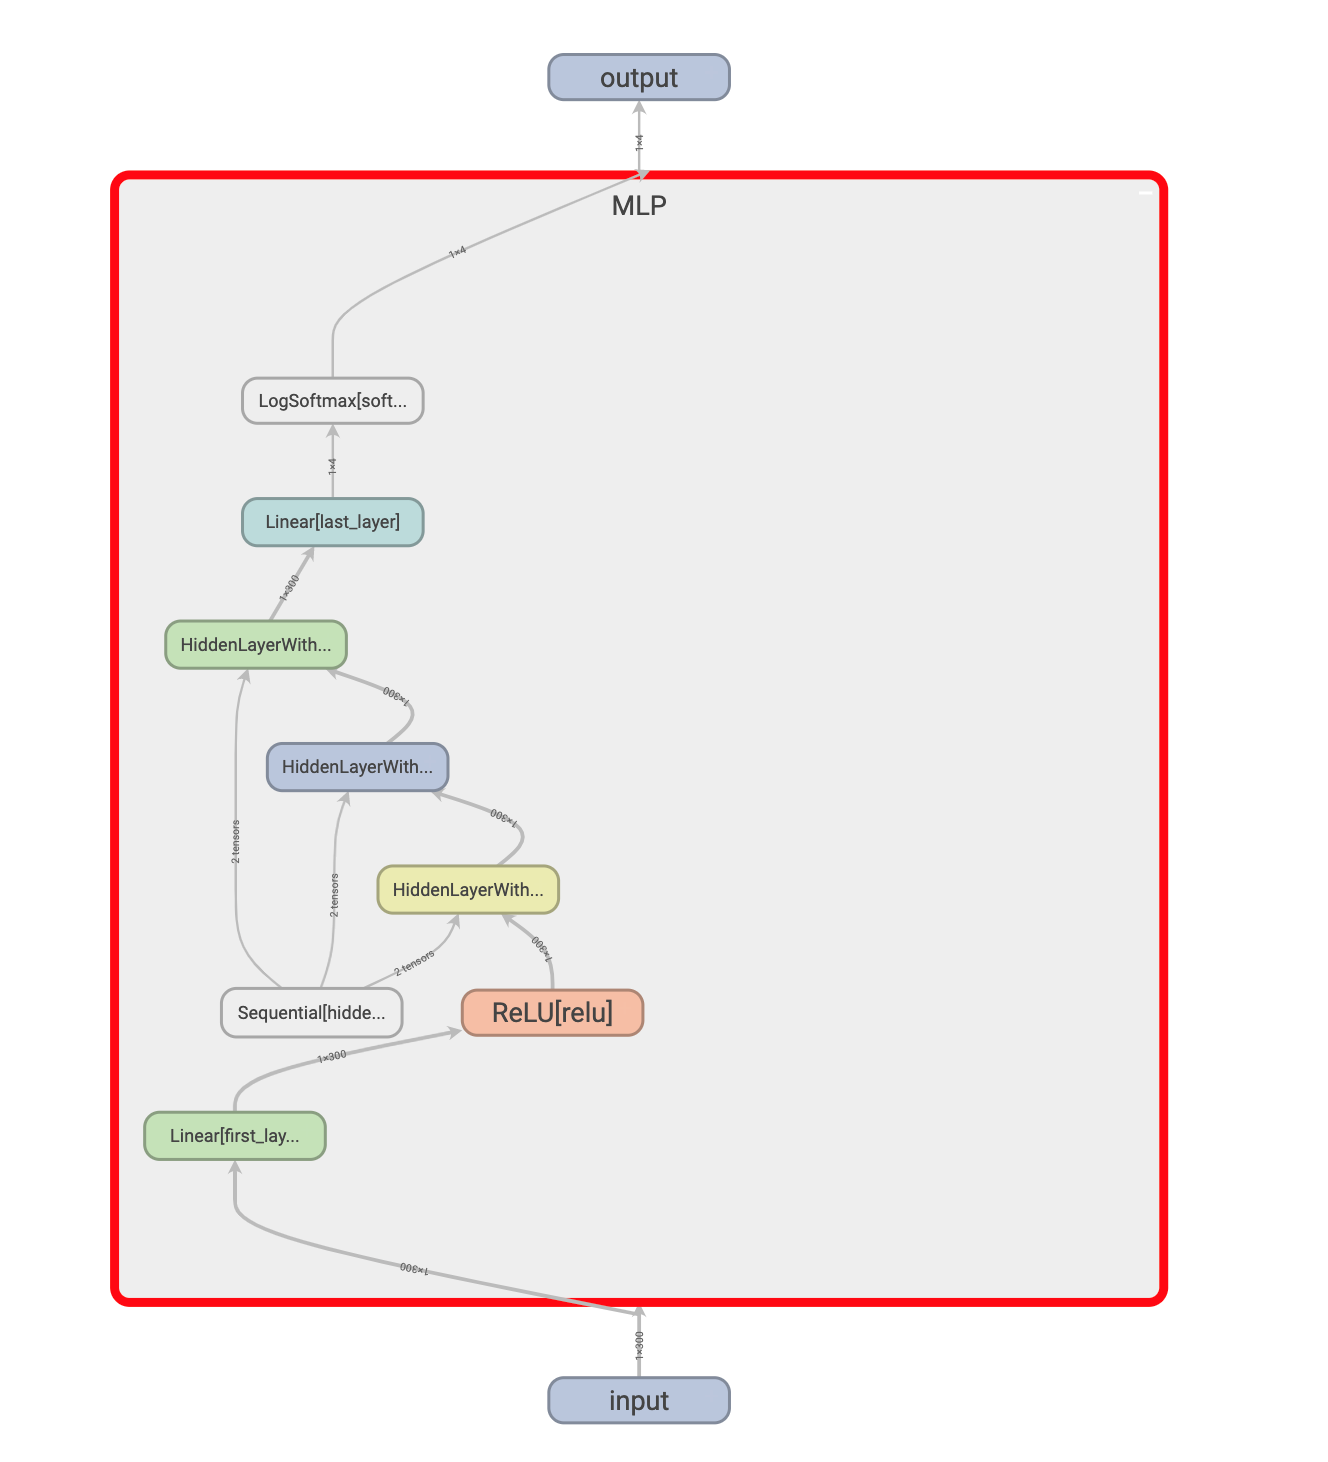

In [76]:
from IPython.display import Image
Image('./work/model.png')

In [78]:
class MyDataSets(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [79]:
def execution(data_x, data_y, op, criterion, model, batch_size=1, is_train=True, use_gpu=False):
    if is_train: model.train()
    else: model.eval()
    ndata = len(data_x)
    dataset = MyDataSets(data_x, data_y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    sum_loss, acc_score = 0, 0
    for batch_x, batch_y in data_loader:
        if use_gpu:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        op.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        if is_train:
            loss.backward()
            op.step()
        sum_loss += loss.data.item() * len(batch_x)
        pred = torch.argmax(out, dim=1)
        acc_score += np.sum((pred == batch_y).cpu().detach().numpy())
    return sum_loss / ndata, acc_score / ndata * 100

In [80]:
train_x = load_file_npy('work/', 'train_x.npy')
train_y = load_file_npy('work/', 'train_y.npy')
valid_x = load_file_npy('work/', 'valid_x.npy')
valid_y = load_file_npy('work/', 'valid_y.npy')
test_x = load_file_npy('work/', 'test_x.npy')
test_y = load_file_npy('work/', 'test_y.npy')

model = MLP(300, 3, 300, 4, 0.5)
ntrain = len(train_x)
nepoch = 100
op = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

In [81]:
%%time
logger = list()
for epoch in tqdm.notebook.tqdm(range(1, nepoch + 1)):
    train_loss, train_acc = execution(train_x, train_y, op, criterion, model, batch_size=256)
    with torch.no_grad():
        valid_loss, valid_acc = execution(valid_x, valid_y, op, criterion, model, batch_size=256, is_train=False)
    logger.append({'epoch':epoch, 'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc})
    if epoch % 5 == 0:
        print({'epoch':epoch, 'train_loss':train_loss, 'train_acc':train_acc, 'valid_loss':valid_loss, 'valid_acc':valid_acc})
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer_state_dict': op.state_dict(),
        }, f'./work/checkpoints/checkpoint_{epoch}.pt')

{'epoch': 5, 'train_loss': 0.5239533301373099, 'train_acc': 78.91385767790263, 'valid_loss': 0.4913346134767997, 'valid_acc': 78.72659176029963}
{'epoch': 10, 'train_loss': 0.40665526492765336, 'train_acc': 84.48501872659176, 'valid_loss': 0.39731507935327537, 'valid_acc': 83.82022471910112}
{'epoch': 15, 'train_loss': 0.35646628322226276, 'train_acc': 87.2003745318352, 'valid_loss': 0.3658876395850592, 'valid_acc': 87.41573033707866}
{'epoch': 20, 'train_loss': 0.3203525919369544, 'train_acc': 89.08239700374531, 'valid_loss': 0.3480262927571486, 'valid_acc': 87.71535580524345}
{'epoch': 25, 'train_loss': 0.2862727624646733, 'train_acc': 90.54307116104869, 'valid_loss': 0.3258889644556724, 'valid_acc': 88.76404494382022}
{'epoch': 30, 'train_loss': 0.24468855092141512, 'train_acc': 92.20973782771536, 'valid_loss': 0.31567374041464447, 'valid_acc': 89.7378277153558}
{'epoch': 35, 'train_loss': 0.21120255942201793, 'train_acc': 93.57677902621722, 'valid_loss': 0.31336146269398235, 'valid

In [83]:
model_100 = MLP(300, 3, 300, 4, 0.5)
checkpoint = torch.load('./work/checkpoints/checkpoint_100.pt')
model_100.load_state_dict(checkpoint['model'])
with torch.no_grad():
    _, test_acc = execution(test_x, test_y, op, criterion, model_100, batch_size=256, is_train=False)
    print(test_acc)

90.2621722846442
